**Establish Connection to Dataset Zip on Google Drive**

This will allow us to directly reference the stored landuseDataset.zip within our drive, and unzip it within Google Colab's current session.

file_id = 1R0z-1tAf9YNIWuyd49cPPCHaCiNqN319

file_name = landUseDataset.zip

In [ ]:
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io

def download_dataset_from_google_drive(file_id = '1R0z-1tAf9YNIWuyd49cPPCHaCiNqN319', file_name = 'landUseDataset.zip'):
  # Authenticate and create the Drive API service
  auth.authenticate_user()
  drive_service = build('drive', 'v3')

  request = drive_service.files().get_media(fileId=file_id)
  fh = io.BytesIO()
  downloader = MediaIoBaseDownload(fh, request)

  done = False
  while done is False:
    status, done = downloader.next_chunk()
    print(f"Download {int(status.progress() * 100)}%")

  with open(file_name, 'wb') as f:
    f.write(fh.getvalue())

  import zipfile
  import os
  extract_path = '/content/'

  with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

  print(f"Contents of {file_name} have been extracted to {extract_path}")

**Steps For Development:**

1. Load data from /content/UCMerced_LandUse/*

  i. Sort into various assortments of training/testing subsets

2. Apply image preprocessing.

  i. Apply noise at a variety of levels

3. Define the neural network models

  i. I.e. Define resnet-50, ViT, and ConvNeXt-Tiny

4. Train the models on the pre-sorted training subsets

5. Test the models on the pre-sorted testing subsets

6. Collect metrics

  i. F1

  ii. Accurracy

  iii. Precision

  iv. Resource usage

  v. etc.

7. Visualize metrics



# **1. Load and Preprocess Images**

In [ ]:
import cv2
import pathlib
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import random

# General dataset constants
DATASET_PATH = pathlib.Path('/content/UCMerced_LandUse/Images')
IMG_DIMENSION = 200
NUM_CLASSES = 2

# Helper function to load images
def load_data(dataset_path=DATASET_PATH, img_width=IMG_DIMENSION, img_height=IMG_DIMENSION, sampling_rate=1.0):
  images = []
  labels = []

  desired_classes = {
      "Nature": ["beach", "river", "forest", "chaparral"],
      "Human Made": ["buildings", "denseresidential", "tenniscourt", "mobilehomepark"]
  }

  class_dirs = sorted(dataset_path.iterdir())
  for class_dir in class_dirs:
    class_name = class_dir.name.lower()

    for category, class_list in desired_classes.items():
      if class_name in class_list:
        image_paths = sorted(class_dir.iterdir())

        sample_image_paths = random.sample(image_paths, int(len(image_paths) * sampling_rate))
        for image_path in sample_image_paths:
          try:
            img = cv2.imread(str(image_path))
            if img is not None:
              img = cv2.resize(img, (IMG_DIMENSION, IMG_DIMENSION))
              images.append(img)
              labels.append(0 if category == "Nature" else 1)  # 0 for Nature, 1 for Human Made

            else:
              print(f"Error loading image: {image_path.name}")
          except Exception as e:
            print(f"Error loading image: {image_path.name}, Error: {e}")
        break

  images = preprocess_input(np.array(images).astype('float32'))
  labels = np.array(labels)
  return images, labels

 # Create data subsets for experiments
def create_subset(X, y, percentage):
  subset_size = int(len(X) * percentage)
  return X[:subset_size], y[:subset_size]

# Add noise to image
def add_noise(image):
  noisy_image = image + 0.2 * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
  noisy_image = np.clip(noisy_image, 0.0, 1.0)
  return noisy_image

# Add noise to dataset as a whole
def apply_noise_to_dataset(X, noise_percentage):
  num_noisy_images = int(len(X) * noise_percentage)
  indices_to_noise = random.sample(range(len(X)), num_noisy_images)
  X_noisy = X.copy()
  for i in indices_to_noise:
    X_noisy[i] = add_noise(X_noisy[i])
  return X_noisy

In [ ]:
if not DATASET_PATH.exists():
  download_dataset_from_google_drive()

# Retrieve the images and classifications of our dataset
images, labels = load_data()

# Split the data into training, validation, and test sets.
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# **2. Define Model Architectures**

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, ConvNeXtTiny
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Model
import time as tm
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### **ResNet-50 Model**

In [ ]:
def build_resnet50(input_shape=(IMG_DIMENSION, IMG_DIMENSION, 3), num_classes=NUM_CLASSES):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(IMG_DIMENSION, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

### **Vision Transformer (ViT)**

In [ ]:
def build_vit(input_shape=(IMG_DIMENSION, IMG_DIMENSION, 3), num_classes=NUM_CLASSES):
    vit_layer = keras.applications.efficientnet_v2.EfficientNetV2S(
        weights="imagenet", include_top=False, input_shape=input_shape
    )
    vit_layer.trainable = True  # Freeze backbone

    x = GlobalAveragePooling2D()(vit_layer.output)
    x = Dense(IMG_DIMENSION, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=vit_layer.input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


### **ConvNeXt-Tiny**

In [ ]:
def build_convnext_tiny(input_shape=(IMG_DIMENSION, IMG_DIMENSION, 3), num_classes=NUM_CLASSES):
    base_model = ConvNeXtTiny(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = True  # Freeze layers

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(IMG_DIMENSION, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# **Train Models**

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

datagen = ImageDataGenerator(
    rescale=1.0/IMG_DIMENSION,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Extend train_model to evaluate and return performance metrics
def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test,
                       epochs=5, batch_size=32, experiment_name="experiment"):
    train_generator = datagen.flow(X_train, y_train, batch_size=batch_size, subset='training')
    val_generator = datagen.flow(X_train, y_train, batch_size=batch_size, subset='validation')

    start_time = tm.time()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1, callbacks=[reduce_lr, early_stop]
    )
    training_time = tm.time() - start_time

    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)
    y_true = y_test

    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    error_rate = 1 - accuracy

    return {
        "Experiment": experiment_name,
        "Accuracy": accuracy,
        "Recall": recall,
        "F1": f1,
        "Precision": precision,
        "Error Rate": error_rate,
        "Training Time": training_time
    }, history, y_pred, y_true

# **Visualize Results**

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def loss_and_accuracy_graph(history, experiment_name):
  training_loss = history.history['loss']
  test_loss = history.history['val_loss']

  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)

  # Visualize loss history
  plt.plot(epoch_count, training_loss, 'r--')
  plt.plot(epoch_count, test_loss, 'b-')
  plt.legend(['Training Loss', 'Test Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f"Epoch vs. Loss {experiment_name}")
  ax = plt.gca()
  ax.set_ylim([0, None])
  plt.show();

  training_accuracy = history.history['accuracy']
  test_accuracy = history.history['val_accuracy']

  # Create count of the number of epochs
  epoch_count = range(1, len(training_accuracy) + 1)

  # Visualize loss history
  plt.plot(epoch_count, training_accuracy, 'r--')
  plt.plot(epoch_count, test_accuracy, 'b-')
  plt.legend(['Training Accuracy', 'Test Accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title(f"Epoch vs. Accuracy {experiment_name}")
  ax = plt.gca()
  ax.set_ylim([0, None])
  plt.show();

def conf_matrix(y_pred, y_val, experiment_name):
  mat = confusion_matrix(y_val, y_pred)
  sns.heatmap(mat, xticklabels=['Nature', 'Human Made'],  yticklabels=['Nature', 'Human Made'], square=True, fmt='d', annot=True, cbar=False)
  plt.xlabel('Predicted Value')
  plt.ylabel('True Value')
  plt.title(f"Confusion Matrix: {experiment_name}")
  plt.show()


In [ ]:
# Code retrieved from here: https://gist.github.com/darien-schettler/cb0724d9fa453607d48b8b5c2a8e1942

def get_colab_usage(pip_install=False, import_libs=True, return_fn=True):
    """ Retrieve Google Colab Resource Utilization Stats

    Args:
        pip_install (bool, optional): Whether to preform pip installs
        import_libs (bool, optional): Whether to import libraries
        return_fn (bool, optional): Whether or not to return get_usage fn

    Returns:
        The get_usage fn ...
            (potentially... only if return_fn flag is set to True)
            ... which can be used to determine resource utilization stats
            at any time in the future of this session without need for
            any pip installs or library imports or fn definitions
    """

    if pip_install:
        # memory footprint support libraries/code
        !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
        !pip install gputil
        !pip install psutil
        !pip install humanize

    if import_libs:
        import psutil
        import humanize
        import os
        import GPUtil as GPU

    def print_resource_usage():
        """Function that actually retrieves resource utilization statistics"""

        # Get the activate GPU
        # TODO >>> GPU not guaranteed to be the only one <<< TODO
        gpu = GPU.getGPUs()[0]

        # Get current process
        process = psutil.Process(os.getpid())

        # Get general ram usage
        gen_ram = humanize.naturalsize(psutil.virtual_memory().available)

        # Get processor size
        proc_size = humanize.naturalsize(process.memory_info().rss)

        # Get gpu stats
        gpu_free_mem  = gpu.memoryFree
        gpu_used_mem  = gpu.memoryUsed
        gpu_util_mem  = gpu.memoryUtil*100
        gpu_total_mem = gpu.memoryTotal

        # Print interpretable resource utilization statistics
        print("\n------------------------------------------------------")
        print("             RESOURCE USAGE STATISTICS                ")
        print("------------------------------------------------------\n")
        print("Gen RAM Free: {:8} | " \
              "Proc size   : {}"\
              "".format(gen_ram, proc_size))

        print("GPU RAM Free: {:4.0f} MB | " \
              "Used        : {:5.0f} MB | " \
              "Util        : {:5.0f}% | " \
              "Total       : {:5.0f}MB\n" \
              "".format(gpu_free_mem, gpu_used_mem,
                        gpu_util_mem, gpu_total_mem))

    # Internally call the fn
    print_resource_usage()

    if return_fn:
        return(print_resource_usage)

# This will print the resource utilization and give us access
# to the fn `get_usage` which can now be called like a regular
# function with no arguments required.
get_usage = get_colab_usage(pip_install=True, return_fn=True)


------------------------------------------------------
             RESOURCE USAGE STATISTICS                
------------------------------------------------------

Gen RAM Free: 10.9 GB  | Proc size   : 1.8 GB
GPU RAM Free: 15092 MB | Used        :     2 MB | Util        :     0% | Total       : 15360MB



# **Execute Experiment**

 = = = = Running experiment on varying noise. = = = =
 --- Training convnext | 100.0% subset: 560 images | 10 epochs | 10.0% Dataset Noise ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6248 - loss: 0.6473 - val_accuracy: 0.9375 - val_loss: 0.2214 - learning_rate: 1.0000e-04
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 636ms/step - accuracy: 0.9301 - loss: 0.1923 - val_accuracy: 0.9375 - val_loss: 0.1432 - learning_rate: 1.0000e-04
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 667ms/step - accuracy: 0.8930 - loss: 0.2666 - val_accuracy: 0.9196 - val_loss: 0.2736 - learning_rate: 1.0000e-04
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 621ms/step - accuracy: 0.8913 - loss: 0.2853 - val_accuracy: 0.9196 - val_loss: 0.2083 - learning_rate: 1.0000e-04
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 630ms/step - accuracy: 0.9077 - loss: 0.2263 - val_accuracy: 0.9554 - val_loss: 0.1358 - learning_rate: 1.0000e-04
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 623ms/step - accuracy: 0.9357 - loss: 0.1600 - val_accuracy: 0.9554 - val_loss: 0.1041 - learning_rate: 1.0000e-04
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 642ms/step - accuracy: 0.

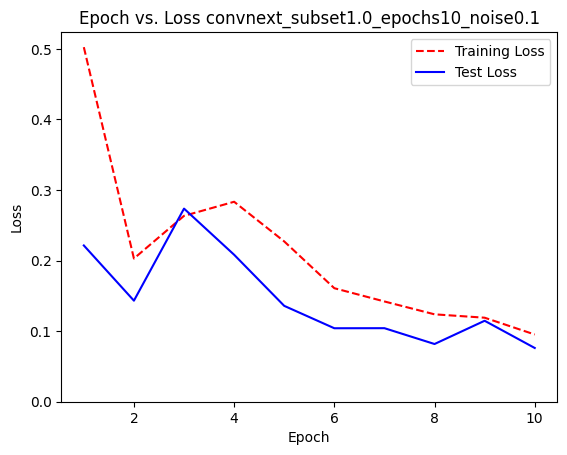

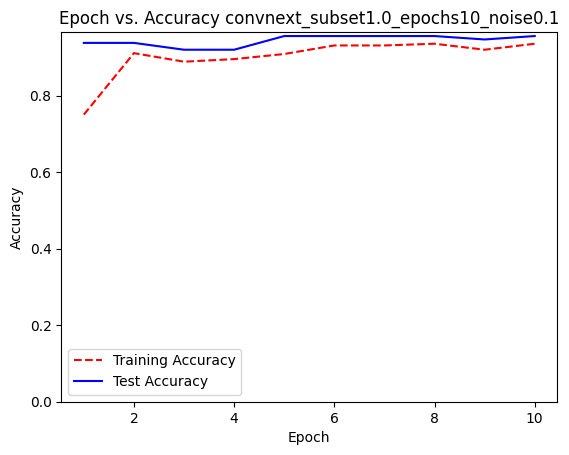

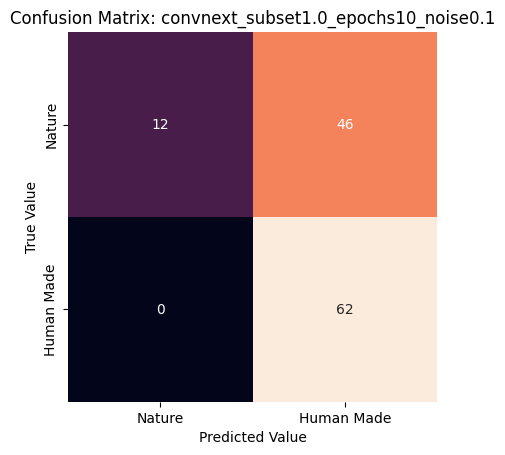


------------------------------------------------------
             RESOURCE USAGE STATISTICS                
------------------------------------------------------

Gen RAM Free: 8.8 GB   | Proc size   : 4.1 GB
GPU RAM Free: 5744 MB | Used        :  9350 MB | Util        :    61% | Total       : 15360MB

<function get_colab_usage.<locals>.print_resource_usage at 0x7f9cea7df740>
 --- Training convnext | 100.0% subset: 560 images | 10 epochs | 20.0% Dataset Noise ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5904 - loss: 0.6731 - val_accuracy: 0.8929 - val_loss: 0.2720 - learning_rate: 1.0000e-04
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 634ms/step - accuracy: 0.8431 - loss: 0.3362 - val_accuracy: 0.9196 - val_loss: 0.1611 - learning_rate: 1.0000e-04
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 667ms/step - accuracy: 0.8738 - loss: 0.2325 - val_accuracy: 0.9018 - val_loss: 0.2083 - learning_rate: 1.0000e-04
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 635ms/step - accuracy: 0.8491 - loss: 0.2827 - val_accuracy: 0.9196 - val_loss: 0.1597 - learning_rate: 1.0000e-04
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 623ms/step - accuracy: 0.8686 - loss: 0.2069 - val_accuracy: 0.9196 - val_loss: 0.1863 - learning_rate: 1.0000e-04
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 622ms/step - accuracy: 0.8576 - loss: 0.2664 - val_accuracy: 0.9286 - val_loss: 0.1419 - learning_rate: 1.0000e-04
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 623ms/step - accuracy: 0.

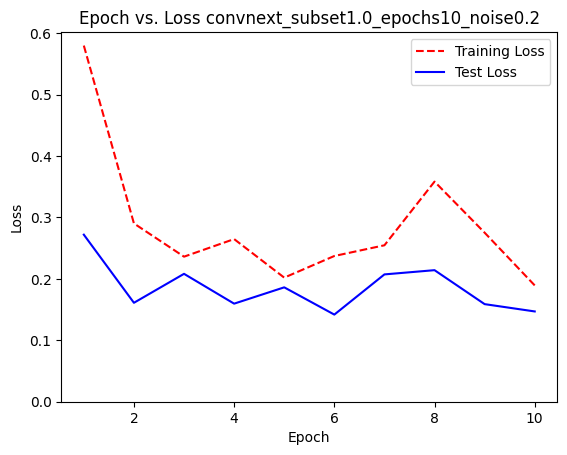

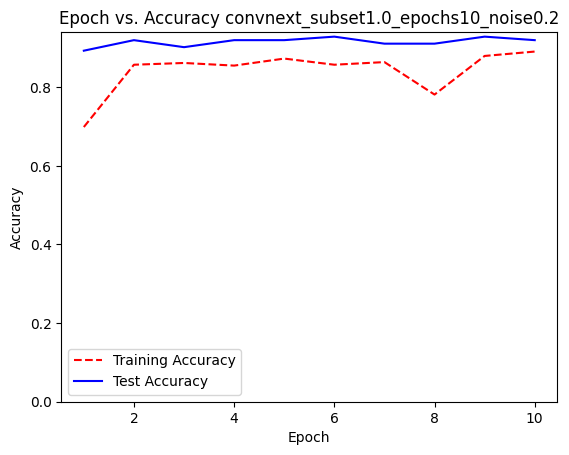

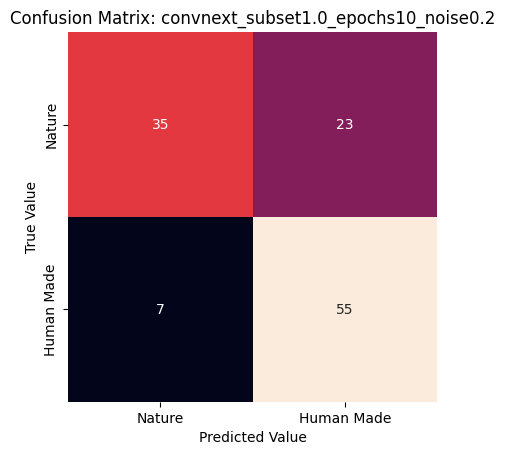


------------------------------------------------------
             RESOURCE USAGE STATISTICS                
------------------------------------------------------

Gen RAM Free: 7.6 GB   | Proc size   : 5.3 GB
GPU RAM Free: 5742 MB | Used        :  9352 MB | Util        :    61% | Total       : 15360MB

<function get_colab_usage.<locals>.print_resource_usage at 0x7f9ce97622a0>
 --- Training convnext | 100.0% subset: 560 images | 10 epochs | 30.0% Dataset Noise ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5958 - loss: 0.7224 - val_accuracy: 0.8036 - val_loss: 0.4740 - learning_rate: 1.0000e-04
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 634ms/step - accuracy: 0.7245 - loss: 0.4945 - val_accuracy: 0.8125 - val_loss: 0.3946 - learning_rate: 1.0000e-04
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 666ms/step - accuracy: 0.8004 - loss: 0.3933 - val_accuracy: 0.7946 - val_loss: 0.3868 - learning_rate: 1.0000e-04
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 637ms/step - accuracy: 0.7721 - loss: 0.3577 - val_accuracy: 0.7768 - val_loss: 0.3764 - learning_rate: 1.0000e-04
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 632ms/step - accuracy: 0.8004 - loss: 0.3291 - val_accuracy: 0.8214 - val_loss: 0.2610 - learning_rate: 1.0000e-04
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 623ms/step - accuracy: 0.8512 - loss: 0.2634 - val_accuracy: 0.8393 - val_loss: 0.2556 - learning_rate: 1.0000e-04
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 649ms/step - accuracy: 0.

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


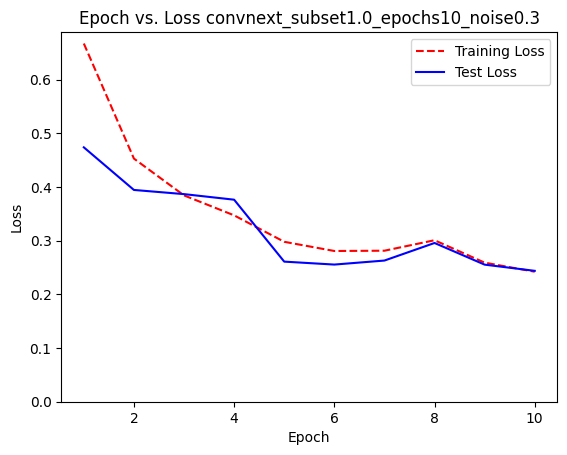

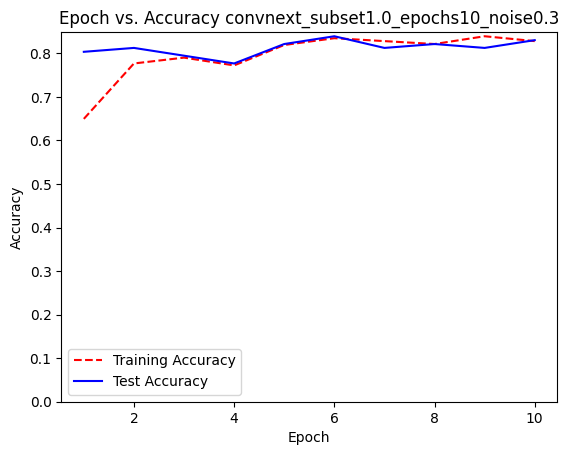

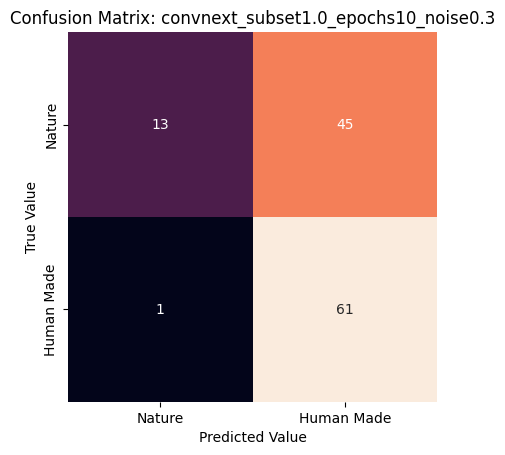


------------------------------------------------------
             RESOURCE USAGE STATISTICS                
------------------------------------------------------

Gen RAM Free: 6.7 GB   | Proc size   : 6.2 GB
GPU RAM Free: 5740 MB | Used        :  9354 MB | Util        :    61% | Total       : 15360MB

<function get_colab_usage.<locals>.print_resource_usage at 0x7f9d92bd79c0>
                             Experiment  Accuracy    Recall        F1  \
0  convnext_subset1.0_epochs10_noise0.1  0.616667  0.603448  0.536134   
1  convnext_subset1.0_epochs10_noise0.2  0.750000  0.745273  0.742857   
2  convnext_subset1.0_epochs10_noise0.3  0.616667  0.604004  0.543651   

   Precision  Error Rate  Training Time  
0   0.787037    0.383333     166.471887  
1   0.769231    0.250000     145.268399  
2   0.752022    0.383333     146.436947  
 = = = = = = 



In [ ]:
results = []

# variables = ['subset', 'epochs', 'noise']
variables = ['noise']


default_subset = 1.0
default_epochs = 10
default_noise = 0.2

# subset_sizes = [0.3, 0.6, 1.0]
# epochs_list = [5, 10, 20]
# noise_percentages = [0.1, 0.2, 0.3]

noise_percentages = [0.1, 0.2, 0.3]

model_builders = {
    # "resnet50": build_resnet50,
    # "vit": build_vit,
    "convnext": build_convnext_tiny
}

for sweep_variable in variables:
  print(f" = = = = Running experiment on varying {sweep_variable}. = = = =")
  # Run sweep based on selected variable
  # if sweep_variable == 'subset':
  #     for subset_percentage in subset_sizes:
  #         X_train_sub, y_train_sub = create_subset(X_train, y_train, subset_percentage)
  #         X_train_sub_noisy = apply_noise_to_dataset(X_train_sub, default_noise)
  #         for model_name, builder in model_builders.items():
  #             print(f" --- Training {model_name} | {subset_percentage * 100}% subset: {len(X_train_sub_noisy)} images | {default_epochs} epochs | {default_noise * 100}% dataset noise ---")
  #             model = builder()
  #             metrics, history, y_pred, y_true = train_and_evaluate(
  #                 model, X_train_sub_noisy, y_train_sub, X_val, y_val, X_test, y_test,
  #                 epochs=default_epochs,
  #                 experiment_name=f"{model_name}_subset{subset_percentage}_epochs{default_epochs}_noise{default_noise}"
  #             )
  #             results.append(metrics)
  #             loss_and_accuracy_graph(history, metrics["Experiment"])
  #             conf_matrix(y_pred, y_true, metrics["Experiment"])
  #         print(get_colab_usage(pip_install=False, return_fn=True))

  # elif sweep_variable == 'epochs':
  #     for epoch_count in epochs_list:
  #         X_train_sub, y_train_sub = create_subset(X_train, y_train, default_subset)
  #         X_train_sub_noisy = apply_noise_to_dataset(X_train_sub, default_noise)
  #         for model_name, builder in model_builders.items():
  #             print(f" --- Training {model_name} | {default_subset}% subset: {len(X_train_sub_noisy)} images | {epoch_count} epochs | {default_noise * 100}% Dataset Noise ---")
  #             model = builder()
  #             metrics, history, y_pred, y_true = train_and_evaluate(
  #                 model, X_train_sub_noisy, y_train_sub, X_val, y_val, X_test, y_test,
  #                 epochs=epoch_count,
  #                 experiment_name=f"{model_name}_subset{default_subset}_epochs{epoch_count}_noise{default_noise}"
  #             )
  #             loss_and_accuracy_graph(history, metrics["Experiment"])
  #             conf_matrix(y_pred, y_true, metrics["Experiment"])
  #             results.append(metrics)
  #         print(get_colab_usage(pip_install=False, return_fn=True))


  if sweep_variable == 'noise':
      for noise_percentage in noise_percentages:
          X_train_sub, y_train_sub = create_subset(X_train, y_train, default_subset)
          X_train_sub_noisy = apply_noise_to_dataset(X_train_sub, noise_percentage)
          for model_name, builder in model_builders.items():
              print(f" --- Training {model_name} | {default_subset * 100}% subset: {len(X_train_sub_noisy)} images | {default_epochs} epochs | {noise_percentage * 100}% Dataset Noise ---")
              model = builder()
              metrics, history, y_pred, y_true = train_and_evaluate(
                  model, X_train_sub_noisy, y_train_sub, X_val, y_val, X_test, y_test,
                  epochs=default_epochs,
                  experiment_name=f"{model_name}_subset{default_subset}_epochs{default_epochs}_noise{noise_percentage}"
              )
              results.append(metrics)
              loss_and_accuracy_graph(history, metrics["Experiment"])
              conf_matrix(y_pred, y_true, metrics["Experiment"])
          print(get_colab_usage(pip_install=False, return_fn=True))

  # get_usage = get_colab_usage(pip_install=False, import_libs=False, return_fn=True)
  results_df = pd.DataFrame(results)
  print(results_df)
  results_df.to_csv(f"{sweep_variable}_results.csv", index=False)
  print(" = = = = = = \n")